In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%%capture

!pip install langchain "unstructured[all-docs]" unstructured-inference pydantic lxml
!pip install --upgrade nltk
!pip uninstall pdfminer.six --y
!pip install pikepdf pypdf wrapt pdfminer.six
!pip install unstructured_pytesseract
# !brew install poppler-utils
# !brew install tesseract-ocr
# !brew install poppler-qt5
# !brew install tesseract-lang
# !brew install tesseract

!sudo apt-get install poppler-utils
!sudo apt install tesseract-ocr

!pip install pillow pydantic lxml pillow matplotlib chromadb tiktoken
!pip install -U langchain openai langchain-chroma langchain-experimental
!pip install lamini
!pip install -U langchain_ollama
!pip install -qU langchain-openai

In [ ]:
import os
from typing import Any

from pydantic import BaseModel
from unstructured.partition.pdf import partition_pdf
from langchain_text_splitters import CharacterTextSplitter

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from unstructured.partition.pdf import partition_pdf
from langchain_text_splitters import CharacterTextSplitter
def extract_pdf_elements(images_path, file_name):
  return partition_pdf(
      filename=file_name,
      extract_images_in_pdf=True,
      strategy="hi_res",
      infer_table_structure=True,
      extract_image_block_output_dir=images_path
  )


def categorize_elements(raw_pdf_elements):
  tables = []
  texts = []

  for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
      tables.append(str(element))
    elif "unstructured.documents.elements.ListItem" in str(type(element)) or "unstructured.documents.elements.NarrativeText" in str(type(element)):
      texts.append(str(element))

  return tables, texts

images_path = "/content/drive/MyDrive/rag/images"
file_name = "/content/drive/MyDrive/rag/13-24.pdf"

raw_pdf_elements = extract_pdf_elements(images_path, file_name)
tables, texts = categorize_elements(raw_pdf_elements)

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
  chunk_size=4000,
  chunk_overlap=0,
)
joined_texts = " ".join(texts)
texts_4k_token = text_splitter.split_text(joined_texts)

In [ ]:
# saving retrieved texts and tables to a file

with open("/content/drive/MyDrive/rag/13-24_text.txt", "w") as f:
  f.write('\n'.join(texts_4k_token))

with open("/content/drive/MyDrive/rag/13-24_table.txt", "w") as f:
  f.write('\n'.join(tables))

In [ ]:
#loading saved texts and tables from file
texts = []
with open("/content/drive/MyDrive/rag/13-24_text.txt", "r") as f:
  for line in f:
    texts.append(line)

tables = []
with open("/content/drive/MyDrive/rag/13-24_table.txt", "r") as f:
  for line in f:
    tables.append(line)

In [ ]:
element_dict = [el.to_dict() for el in raw_pdf_elements]

unique_types = set()
for item in element_dict:
  unique_types.add(item['type'])

print(unique_types)

{'UncategorizedText', 'ListItem', 'FigureCaption', 'Table', 'Title', 'Footer', 'Header', 'NarrativeText', 'Image'}


In [ ]:
# from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

import os
import lamini
from lamini import Lamini
from dotenv import load_dotenv

In [ ]:
print(tables)

['Chylomicron VLDL IDL LDL HDL <0.94 0.94–1.006 1.006–1.019 1.006–1.063 1.063–1.210 Protein Triglyceride Cholesterol Phospholipid origin 1–2 85–95 3–7 3–6 Intestine Transport dietary CH and TG to liver 6–10 50–65 20–30 15–20 Intestine and liver Transport endogenous TG and CH 12–18 20–50 20–40 15–25 Produced from VLDL Transport endogenous TG and CH 18–22 4–8 51–58 18–24 Product of IDL catabolism Transport endogenous CH to cells 45–55 2–7 18–25 26–32 Liver and intestine Cream layer Turbid Clear Clear Clear Origin Pre-β Slow pre-β β α mobility A-IV, B-48, C-I, B-100, C-I, B-100, C-I, B-100, (a) C-II, C-III C-III, C-III, E C-II, C-III, E\n', 'Effect on Plasma Lipids Cholesterol (%) Triglycerides (%) HDL-C (%) Comments Diuretics Thiazides Loop Indapamide Metolazone Potassium-sparing β-Blockers Nonselective ↑5–7 initially ↑0–3 later No change No change No change No change No change ↑30–50 No change No change No change No change ↑20–50 ↑1 ↓ to 15 No change No change No change ↓10–15 Effects t

In [ ]:
import os
import time
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
import load_dotenv

load_dotenv()
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]

def generate_text_summaries(texts, tables, summarize_texts=False):

    prompt_text = """You are an assistant tasked with summarizing tables and text for retrieval. \
    These summaries will be embedded and used to retrieve the raw text or table elements. \
    Give a concise summary of the table or text that is well optimized for retrieval. Table or text: {element} """

    prompt = ChatPromptTemplate.from_template(prompt_text)

    model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

    text_summaries = []
    table_summaries = []

    if texts and summarize_texts:
      text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})
    elif texts:
        text_summaries = texts

    if tables:
      time.sleep(60)
      table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

    return text_summaries, table_summaries

text_summaries, table_summaries = generate_text_summaries(texts=texts, tables=tables, summarize_texts=True)

In [ ]:
print(len(texts))

1


In [ ]:
print(len(table_summaries))

114


In [ ]:
import base64
from io import BytesIO

from IPython.display import HTML, display_html
from PIL import Image

from langchain_core.messages import HumanMessage
# from langchain_ollama import ChatOllama
from langchain_community.llms import Ollama

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode("utf-8")
    return encoded_string


def image_summarize(img_base64, prompt):

    chat = ChatOpenAI(model="gpt-4o-mini", max_tokens=1024)

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64, {img_base64}"
                            },
                    }
                ]
            )
        ]
    )

    return msg.content

def generate_img_summaries(path):
    img_base64_list = []

    image_summaries = []

    prompt = """"You are an assistant tasked with summarizing these images for retrieval. \
                These summaries will be embedded and used to retrieve the raw image. \
                Give a concise summary of the image that is well optimized for retrieval."""

    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(".jpg"):
            img_path = os.path.join(path, img_file)
            img_base64 = encode_image(img_path)
            img_base64_list.append(img_base64)

            image_summaries.append(image_summarize(img_base64, prompt))

    return img_base64_list, image_summaries

# Image summaries
images_path = "/content/drive/MyDrive/rag/images"
img_base64_list, image_summaries = generate_img_summaries(images_path)

In [ ]:
# saving generated summaries to a file
import pickle

with open("/content/drive/MyDrive/rag/text_summaries.txt", "wb") as f:
  pickle.dump(text_summaries, f)

with open("/content/drive/MyDrive/rag/table_summaries.txt", "wb") as f:
  pickle.dump(table_summaries, f)

with open("/content/drive/MyDrive/rag/image_summaries.txt", "wb") as f:
  pickle.dump(image_summaries, f)

with open("/content/drive/MyDrive/rag/img_base64_list.txt", "wb") as f:
  pickle.dump(img_base64_list, f)

In [ ]:
# loading generated summaries to a file
text_summaries = []
table_summaries= []
image_summaries = []
img_base64_list = []

import pickle

with open("/content/drive/MyDrive/rag/text_summaries.txt", "rb") as f:
  text_summaries = pickle.load(f)

with open("/content/drive/MyDrive/rag/table_summaries.txt", "rb") as f:
  table_summaries = pickle.load(f)

with open("/content/drive/MyDrive/rag/image_summaries.txt", "rb") as f:
  image_summaries = pickle.load(f)

with open("/content/drive/MyDrive/rag/img_base64_list.txt", "rb") as f:
  img_base64_list= pickle.load(f)

In [ ]:
print(len(tables))

114


In [ ]:
print(len(table_summaries))

114


In [ ]:
import uuid
import os

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings
# from langchain_ollama import OllamaEmbeddings

def create_multi_vector_retriever(vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, img_base64_list):

  store = InMemoryStore()
  id_key = "doc_id"

  retriever = MultiVectorRetriever(
      vectorstore=vectorstore,
      docstore=store,
      id_key=id_key
  )

  def add_documents(retriever, doc_summaries, doc_contents):
    doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
    summary_docs = [
        Document(page_content=s, metadata={id_key: doc_ids[i]})
        for i, s in enumerate(doc_summaries)
    ]
    retriever.vectorstore.add_documents(summary_docs)
    # doc_contents = doc_contents + [None] * (len(doc_summaries) - len(doc_contents))
    retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

  if text_summaries:
    add_documents(retriever, text_summaries, texts)
  if table_summaries:
    add_documents(retriever, table_summaries, tables)
  if image_summaries:
    add_documents(retriever, image_summaries, img_base64_list)

  return retriever

vectorstore = Chroma(
    collection_name="rag",
    embedding_function=OpenAIEmbeddings(),
    persist_directory="/content/drive/MyDrive/rag/db"
)

multi_vector_retriever = create_multi_vector_retriever(
    vectorstore,
    text_summaries,
    texts,
    table_summaries,
    tables,
    image_summaries,
    img_base64_list)


In [ ]:
import io
import re

from IPython.display import HTML, display
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from PIL import Image

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage

def plt_imge_base64(img_base64):
  image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
  display(HTML(image_html))

def looks_like_base64(sb):
  return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None

def is_image_data(b64data):
  image_signatures = {
      b"\xff\xd8\xff": "jpg",
      b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
      b"\x47\x49\x46\x38": "gif",
      b"\x52\x49\x46\x46": "webp",
  }
  try:
    header = base64.b64decode(b64data)[:8]
    for sig, format in image_signatures.items():
      if header.startswith(sig):
        return True
    return False
  except Exception:
    return False

def resize_base64_image(base64_string, size=(128, 128)):
  img_data = base64.b64decode(base64_string)
  img = Image.open(io.BytesIO(img_data))

  resized_img = img.resize(size, Image.LANCZOS)
  buffered = io.BytesIO()
  resized_img.save(buffered, format=img.format)

  return base64.b64encode(buffered.getvalue()).decode("utf-8")

def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            try: # Try to resize the image, if it fails, skip it
                doc = resize_base64_image(doc, size=(1300, 600))
                b64_images.append(doc)
            except Exception as e:
                pass
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict):
    """
    Join the context into a single string
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)

    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": (
            "You are medical doctor tasked with providing clinical decisions.\n"
            "You will be given a mix of text, tables, and image(s) usually of graphs, inforgraphics, x-rays, CT scans and MRIs.\n"
            "Use this information to provide clinical information related to the user question. \n"
            f"User-provided question: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]


def multi_modal_rag_chain(retriever):
    """
    Multi-modal RAG chain
    """

    # Multi-modal LLM
    model = ChatOpenAI(temperature=0, model="gpt-4o-mini", max_tokens=1024)

    # RAG pipeline
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain


# Create RAG chain
chain_multimodal_rag = multi_modal_rag_chain(multi_vector_retriever)

###### Testing the retriever


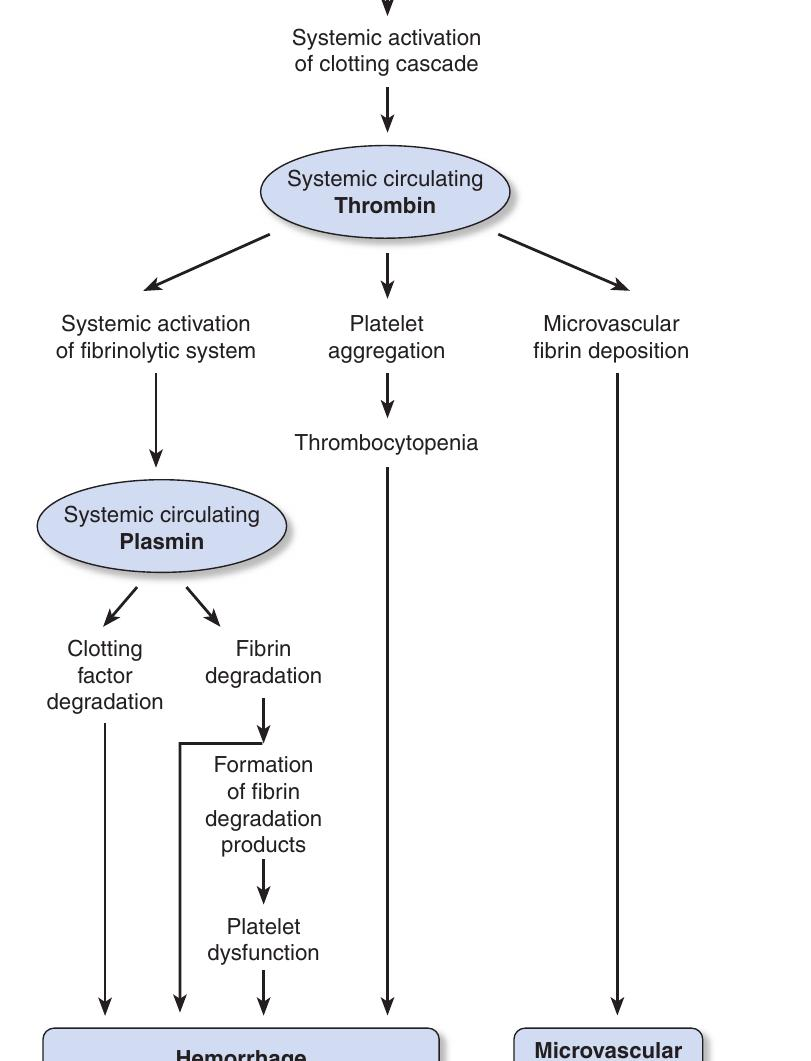

In [ ]:
query = "What triggers platelet aggregation"
result = multi_vector_retriever.invoke(query)
plt_imge_base64(result[0])

###### testing rag

In [ ]:
query = "Tell me about atherosclerosis"
print(chain_multimodal_rag.invoke(query))

### Overview of Atherosclerosis

Atherosclerosis is a chronic inflammatory disease characterized by the buildup of plaques within the arterial walls, leading to narrowed arteries and reduced blood flow. It is a significant contributor to cardiovascular diseases, including coronary artery disease (CAD), myocardial infarction (heart attack), and stroke.

#### Pathophysiology
- **Cholesterol and Lipoproteins**: Cholesterol is essential for various bodily functions, but elevated levels, particularly low-density lipoprotein cholesterol (LDL-C), are directly linked to the development of atherosclerosis. LDL-C accounts for 60% to 70% of total cholesterol and is the primary contributor to plaque formation. Conversely, high-density lipoprotein cholesterol (HDL-C) helps transport cholesterol from peripheral tissues back to the liver, and higher levels are considered protective against atherosclerosis.
- **Plaque Formation**: The process begins with endothelial injury, which can be caused by fact

### Assesing RAG retrieval performance

In [ ]:
%%capture
!pip install trulens trulens-apps-langchain trulens-providers-openai

In [ ]:
from trulens.apps.langchain import TruChain
from trulens.core import TruSession

session = TruSession()
session.reset_database()

🦑 TruSession initialized with db url sqlite:///default.sqlite .
🛑 Secret keys may be written to the database. See the `database_redact_keys` option of `TruSession` to prevent this.


In [ ]:
import numpy as np
from trulens.core import Feedback
from trulens.providers.openai import OpenAI

# Initialize provider class
provider = OpenAI()

# select context to be used in feedback. the location of context is app specific.
context = TruChain.select_context(chain_multimodal_rag)

# Define a groundedness feedback function
f_groundedness = (
    Feedback(
        provider.groundedness_measure_with_cot_reasons, name="Groundedness"
    )
    .on(context.collect())  # collect context chunks into a list
    .on_output()
)

# Question/answer relevance between overall question and answer.
f_answer_relevance = Feedback(
    provider.relevance_with_cot_reasons, name="Answer Relevance"
).on_input_output()
# Context relevance between question and each context chunk.
f_context_relevance = (
    Feedback(
        provider.context_relevance_with_cot_reasons, name="Context Relevance"
    )
    .on_input()
    .on(context)
    .aggregate(np.mean)
)

✅ In Groundedness, input source will be set to __record__.app.first.steps__.context.first.invoke.rets[:].page_content.collect() .
✅ In Groundedness, input statement will be set to __record__.main_output or `Select.RecordOutput` .
✅ In Answer Relevance, input prompt will be set to __record__.main_input or `Select.RecordInput` .
✅ In Answer Relevance, input response will be set to __record__.main_output or `Select.RecordOutput` .
✅ In Context Relevance, input question will be set to __record__.main_input or `Select.RecordInput` .
✅ In Context Relevance, input context will be set to __record__.app.first.steps__.context.first.invoke.rets[:].page_content .


In [ ]:
tru_recorder = TruChain(
    chain_multimodal_rag,
    app_name="ChatApplication",
    app_version="Chain1",
    feedbacks=[f_answer_relevance, f_context_relevance, f_groundedness],
)

In [ ]:
with tru_recorder as recording:
    llm_response = chain_multimodal_rag.invoke("Tell me about atherosclerosis")

display(llm_response)

'### Atherosclerosis Overview\n\n**Definition**: Atherosclerosis is a chronic inflammatory disease characterized by the buildup of plaques (atheromas) within the arterial walls, leading to narrowed arteries and reduced blood flow.\n\n#### Pathophysiology\n- **Cholesterol and Lipoproteins**: \n  - **LDL-C (Low-Density Lipoprotein Cholesterol)**: The primary contributor to atherosclerosis, accounting for 60-70% of total cholesterol.\n  - **HDL-C (High-Density Lipoprotein Cholesterol)**: Helps transport cholesterol from peripheral tissues to the liver; higher levels are protective.\n  - **VLDL-C (Very-Low-Density Lipoprotein Cholesterol)**: Contributes to total cholesterol but to a lesser extent.\n\n- **Inflammation**: Atherosclerosis begins with endothelial injury, leading to inflammation and the accumulation of lipids, immune cells, and fibrous tissue in the arterial wall.\n\n#### Risk Factors\n- **Modifiable**: \n  - High LDL cholesterol\n  - Low HDL cholesterol\n  - Hypertension\n  - 

In [ ]:
session.get_leaderboard()

,,Answer Relevance,latency,total_cost
app_name,app_version,,,
ChatApplication,Chain1,1.0,18.0,0.023707


### RAG_enhanced Inference

In [ ]:
!git clone https://github.com/onyekaokonji/LLaVA-Med.git LLaVA_Med

Cloning into 'LLaVA_Med'...
remote: Enumerating objects: 389, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 389 (delta 32), reused 70 (delta 30), pack-reused 306 (from 1)
Receiving objects: 100% (389/389), 77.07 MiB | 14.17 MiB/s, done.
Resolving deltas: 100% (104/104), done.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
os.chdir("/content/LLaVA_Med")

In [ ]:
%%capture
!pip install -q -e .

In [ ]:
from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path

model_path_2 = "onyekaokonji/llava-med-v1.5-mistral-7b-oo"

tokennizer, model, image_processor, context_len = load_pretrained_model(
    model_path=model_path_2,
    # model_base=model_base,
    model_base=None,
    # model_name=get_model_name_from_path(model_name),
    model_name=get_model_name_from_path(model_path_2)
)

tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.41k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/73.2k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/262M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.76k [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of the model checkpoint at microsoft/llava-med-v1.5-mistral-7b were not used when initializing LlavaMistralForCausalLM: ['model.vision_tower.vision_tower.vision_model.embeddings.class_embedding', 'model.vision_tower.vision_tower.vision_model.embeddings.patch_embedding.weight', 'model.vision_tower.vision_tower.vision_model.embeddings.position_embedding.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm1.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm1.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm2.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm2.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.mlp.fc1.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.mlp.fc1.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.mlp.fc2.bias', 'model.vision_tower.vision_tower.vision_model.encoder.la

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

In [ ]:
%%capture
%pip install --force-reinstall pydantic
%pip install gradio

In [ ]:
question = "what is the modality of this image? is there a disease identifiable in the image and if so, tell me a bit more about it including treatment options"
context = chain_multimodal_rag.invoke(question)
print(context)

The provided images appear to be a series of medical images, likely X-rays or CT scans, but without visual inspection, I cannot definitively identify the modality. However, based on the context of your question, I will assume that the images are related to a specific disease process.

### Identifiable Disease
If the images depict a condition such as pneumonia, lung nodules, or other pulmonary diseases, here are some details:

1. **Pneumonia**:
   - **Description**: Pneumonia is an infection that inflames the air sacs in one or both lungs, which may fill with fluid or pus. Symptoms include cough, fever, chills, and difficulty breathing.
   - **Diagnosis**: Typically diagnosed through a combination of physical examination, chest X-ray, and sometimes CT scans.
   - **Treatment**: Treatment usually involves antibiotics for bacterial pneumonia, antiviral medications for viral pneumonia, and supportive care such as rest, fluids, and over-the-counter medications to relieve symptoms.

2. **Lun

In [ ]:
import gradio as gr
import io
from contextlib import redirect_stdout

from llava.eval.run_llava import eval_model

with gr.Blocks(theme=gr.themes.Monochrome()) as gradio_app:
    with gr.Column(scale=1):
        gr.Markdown("<center><h1>LLaVa-Med + RAG</h1></center>")

        with gr.Row():
            image = gr.Image(type="filepath", scale=2)
            question = gr.Textbox(placeholder="Enter a question", scale=3)

        with gr.Row():
            answer = gr.Textbox(placeholder="Answer pops up here", scale=1)

        def run_inference(image, question):
            # context = chain_multimodal_rag.invoke(question)
            # enhanced_query = f"Question: {question}\n\nAdditional Context: {context}\n\nPlease analyze the image {image} and answer the question based on the given context."
            args = type('Args', (), {
                "model_path": model_path_2,
                "model_base": None,
                "image_file": image,
                "query": question,
                "conv_mode": None,
                "sep": ",",
                "temperature": 0,
                "top_p": None,
                "num_beams": 1,
                "max_new_tokens": 512
                })()

            # Capture the printed output of eval_model
            f = io.StringIO()
            with redirect_stdout(f):
                eval_model(args)
            output = f.getvalue()

            return output

        with gr.Row():
            btn = gr.Button("Run Inference", scale=1)

        btn.click(fn=run_inference, inputs=[image, question], outputs=answer)

gradio_app.launch(share=True, debug=True, height=800, width="100%")

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://471114e699521e29ca.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://471114e699521e29ca.gradio.live
